# FCN 做语义分割

## 介绍
语义分割是一种像素级别的处理图像方式，对比于目标检测其更加精确，能够自动从图像中划分出对象区域并识别对象区域中的类别，比如下面这个效果

![](https://ws4.sinaimg.cn/large/006tKfTcly1fmxq9pslijj30dm0e2q9p.jpg)

上面是输入的图片，下面是希望得到的效果，也就是希望能够对区域进行像素级别的划分

在 2015 年 CVPR 的一篇论文 [Fully Convolutional Networks for Semantic Segmentation](http://link.zhihu.com/?target=https%3A//arxiv.org/abs/1411.4038) 这篇文章提出了全卷积的概念，第一次将端到端的卷积网络推广到了语义分割的任务当中，随后出现了很多基于 FCN 实现的网络结构，比如 U-Net 等。

## 数据集
首先我们需要下载数据集，这里我们使用 [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) 数据集，其是一个正在进行的目标检测,目标识别,语义分割的挑战，我们可以进行数据集的[下载](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar)

下载完成数据集之后进行解压，我们可以再 `ImageSets/Segmentation/train.txt` 和 `ImageSets/Segmentation/val.txt` 中找到我们的训练集和验证集的数据，图片存放在 `/JPEGImages` 中，后缀是 `.jpg`，而 label 存放在 `/SegmentationClass` 中，后缀是 `.png`

我们可以可视化一下

In [1]:
# 导入需要的包
import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from mxtorch import transforms as tfs
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

/home/test/anaconda3/envs/mx/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
im_show1 = Image.open('./dataset/VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
label_show1 = Image.open('./dataset/VOCdevkit/VOC2012/SegmentationClass/2007_005210.png').convert('RGB')
im_show2 = Image.open('./dataset/VOCdevkit/VOC2012/JPEGImages/2007_000645.jpg')
label_show2 = Image.open('./dataset/VOCdevkit/VOC2012/SegmentationClass/2007_000645.png').convert('RGB')

(500, 281)
(500, 375)


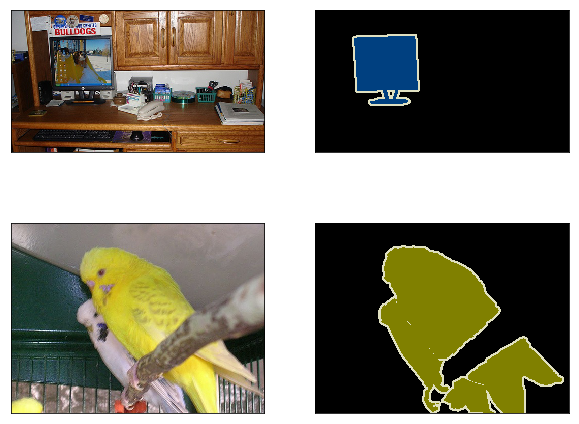

In [3]:
_, figs = plt.subplots(2, 2, figsize=(10, 8))
figs[0][0].imshow(im_show1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].imshow(label_show1)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
figs[1][0].imshow(im_show2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].imshow(label_show2)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(im_show1.size)
print(im_show2.size)

首先输出图片的大小，左边就是真实的图片，右边就是分割之后的结果

然后我们定义一个函数进行图片的读入，根据 `train.txt` 和 `val.txt` 中的文件名进行图片读入，我们不需要这一步就读入图片，只需要知道图片的路径，之后根据图片名称生成 batch 的时候再读入图片，并做一些数据预处理

In [4]:
voc_root = './dataset/VOCdevkit/VOC2012'

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
    return data, label

可能你已经注意到了前面展示的两张图片的大小是不一样的，如果我们要使用一个 batch 进行计算，我们需要图片的大小保持一致，在前面使用卷积网络进行图片分类的任务中，我们通过 resize 的办法对图片进行了缩放，使得他们的大小相同，但是这里会遇到一个问题，对于输入图片我们当然可以 resize 成任意我们想要的大小，但是 label 也是一张图片，且是在 pixel 级别上的标注，所以我们没有办法对 label 进行有效的 resize 似的其也能达到像素级别的匹配，所以为了使得输入的图片大小相同，我们就使用 crop 的方式来解决这个问题，也就是从一张图片中 crop 出固定大小的区域，然后在 label 上也做同样方式的 crop。

使用 crop 可以使用 pytorch 中自带的 transforms，不过要稍微改一下，不仅输出 crop 出来的区域，同时还要输出对应的坐标便于我们在 label 上做相同的 crop

In [5]:
def random_crop(data, label, crop_size):
    height, width = crop_size
    data, rect = tfs.RandomCrop((height, width))(data)
    label = tfs.FixedCrop(*rect)(label)
    return data, label

下面我们可以验证一下随机 crop

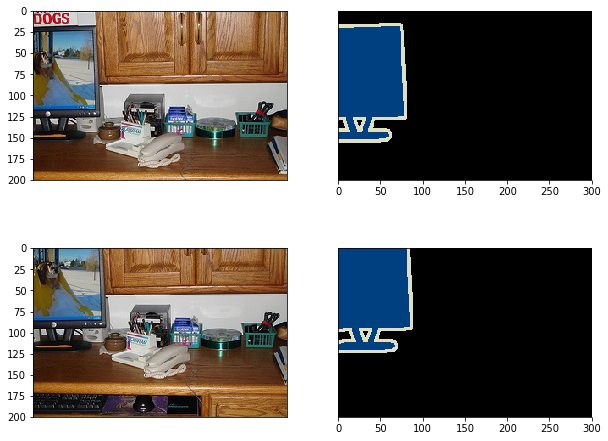

In [6]:
_, figs = plt.subplots(2, 2, figsize=(10, 8))
crop_im1, crop_label1 = random_crop(im_show1, label_show1, (200, 300))
figs[0][0].imshow(crop_im1)
figs[0][1].imshow(crop_label1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
crop_im2, crop_label2 = random_crop(im_show1, label_show1, (200, 300))
figs[1][0].imshow(crop_im2)
figs[1][1].imshow(crop_label2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)

上面就是我们做两次随机 crop 的结果，可以看到图像和 label 能够完美的对应起来

接着我们根据数据知道里面有 21 中类别，同时给出每种类别对应的 RGB 值

In [7]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

接着可以建立一个索引，也就是将一个类别的 RGB 值对应到一个整数上，通过这种一一对应的关系，能够将 label 图片变成一个矩阵，矩阵和原图片一样大，但是只有一个通道数，也就是 (h, w) 这种大小，里面的每个数值代表着像素的类别

In [8]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

定义完成之后，我们可以验证一下

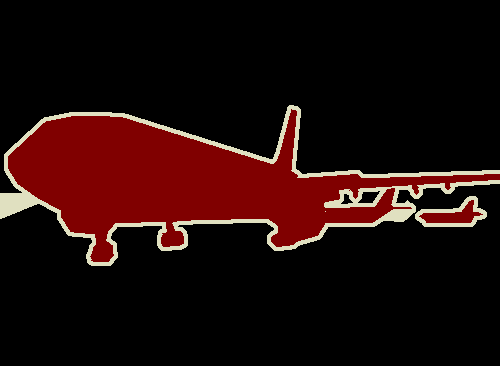

In [9]:
label_im = Image.open('./dataset/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png').convert('RGB')
label_im

In [10]:
label = image2label(label_im)
label.shape

(366, 500)

In [11]:
label[150:160, 240:250]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

可以看到上面的像素点由 0 和 1 构成，0 表示背景，1 表示 飞机这个类别

接着我们可以定义数据预处理方式，之前我们读取的数据只有文件名，现在我们开始做预处理，非常简单，首先随机 crop 出固定大小的区域，然后使用 ImageNet 的均值和方差做标准化。

In [12]:
def img_transforms(img, label, crop_size):
    img, label = random_crop(img, label, crop_size)
    img_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

最后我们定义一个 COVSegDataset 继承于 `torch.utils.data.Dataset` 构成我们自定的训练集

In [13]:
class VOCSegDataset(Dataset):
    '''
    voc dataset
    '''
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [14]:
# 实例化数据集
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape, img_transforms)
voc_test = VOCSegDataset(False, input_shape, img_transforms)

train_data = DataLoader(voc_train, 64, shuffle=True, num_workers=4)
valid_data = DataLoader(voc_test, 128, num_workers=4)

Read 1114 images
Read 1078 images


## fcn 模型
fcn 模型非常简单，里面全部是由卷积构成的，所以被称为全卷积网络，同时由于全卷积的特殊形式，因此可以接受任意大小的输入，网络的示意图如下

![](https://ws4.sinaimg.cn/large/006tKfTcly1fmxwr0flouj30cg06bjsm.jpg)

对于任何一张输入图片，由于卷积层和池化层的不断作用，得到的输出形状会越来越小，但是通道数会越来越大，比如 ResNet18，会将输入的长宽减小 32 倍，由 3x244x244 变成 512x7x7，也就是上图的第一部分，得到的特征图会特别小，最后通过一个转置卷积得到一个和输入形状一样的结果，这里我们引入了转置卷积的概念，下面我们讲一讲什么是转置卷积

### 转置卷积
我们首先可以看看下面的动画

![](https://ws2.sinaimg.cn/large/006tKfTcly1fmxxmlz66dg306s077t9g.gif)

![](https://ws3.sinaimg.cn/large/006tKfTcly1fmxxn64nlyg309k0aqgps.gif)

第一张就是我们常说的卷积的效果，而转置卷积就是下面这个操作，相当于卷积的逆过程，将卷积的输入和输出反过来，卷积的正向传播相当于图片左乘一个矩阵 c，反向传播相当于左乘 $c^T$，而转置卷积的正向过程相当于左乘 $c^T$，反向过程相当于左乘 $(c^T)^T = c$，详细的推导可以看看[论文](https://arxiv.org/pdf/1603.07285.pdf)

而转置卷积的计算公式也非常简单，对于卷积

$$
n_{out} = \frac{n_{in} - kernel + 2 padding}{stride} + 1
$$

转置卷积就是将输入和输出反过来，即

$$
n_{in} = \frac{n_{out} - kernel + 2 padding}{stride} + 1
$$

如果我们希望输出变成输入的两倍，那么 stride 取 2，kernel 和 padding 可以对应着取，比如 kernel 取 4，那么 padding 就取 1

在 pytorch 中转置卷积可以使用 `torch.nn.ConvTranspose2d()` 来实现，下面我们举个例子

In [15]:
x = torch.randn(1, 3, 120, 120)
conv_trans = nn.ConvTranspose2d(3, 10, 4, stride=2, padding=1)
y = conv_trans(Variable(x))
print(y.shape)

torch.Size([1, 10, 240, 240])


可以看到输出变成了输入的 2 倍

### 模型结构
最简单的 fcn 前面是一个去掉全连接层的预训练网络，然后将去掉的全连接变为 1x1 的卷积，输出和类别数目相同的通道数，比如 voc 数据集是 21 分类，那么输出的通道数就是 21，然后最后接一个转置卷积将结果变成输入的形状大小，最后在每个 pixel 上做一个分类问题，使用交叉熵作为损失函数就可以了。

当然这样的模型是特别粗糙的，因为最后一步直接将图片扩大了 32 倍，所以论文中有一个改进，就是将网络中间的输入联合起来进行转置卷积，这样能够依赖更多的信息，所以可以得到更好的结果，可以看看下面的图示

![](https://ws2.sinaimg.cn/large/006tKfTcgy1fmxyqu1mibj31eq0lqadr.jpg)

fcn-32s 就是直接将最后的结果通过转置卷积扩大 32 倍进行输出，而 fcn-16x 就是联合前面一次的结果进行 16 倍的输出，fcn-8x 就是联合前面两次的结果进行 8 倍的输出，我们用上图中 fcn-8x 举例，就是先将最后的结果通过转置卷积扩大 2 倍，然后和 pool4 的结果相加，然后在通过转置卷积扩大 2 倍，然后和 pool3 的结果相加，最后通过转置卷积扩大 8 倍得到和输入形状一样大的结果。

### bilinear kernel
通常我们训练的时候可以随机初始化权重，但是在 fcn 的网络中，使用随机初始化的权重将会需要大量的时间进行训练，所以我们卷积层可以使用在 imagenet 上预训练的权重，那么转置卷积我们使用什么样的初始权重呢？这里就要用到 bilinear kernel。

我们可以看看下面的例子

In [16]:
# 定义 bilinear kernel
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

(281, 500, 3)


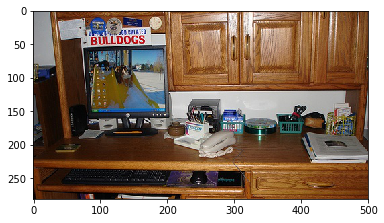

In [17]:
x = Image.open('./dataset/VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
x = np.array(x)
plt.imshow(x)
print(x.shape)

(562, 1000, 3)


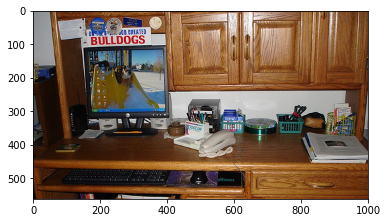

In [18]:
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)
# 定义转置卷积
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)

y = conv_trans(Variable(x)).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

可以看到通过双线性的 kernel 进行转置卷积，图片的大小扩大了一倍，但是图片看上去仍然非常的清楚，所以这种方式的上采样具有很好的效果

下面我们使用 resnet 34 代替论文中的 vgg 实现 fcn

In [19]:
from mxtorch.vision import model_zoo

In [20]:
# 使用预训练的 resnet 34
pretrained_net = model_zoo.resnet34(pretrained=True)

num_classes = len(classes)

我们可以看看 resnet34 的结构

In [21]:
pretrained_net

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

这里我们去掉最后的 avgpool 和 fc 层，使用 `list(pretrained_net.children())[:-2]` 就能够取到倒数第三层

下面我们开始定义我们的网络结构，就像上面显示的一样，我们会取出最后的三个结果进行合并

In [22]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
        
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s

In [23]:
net = fcn(num_classes)
net = net.cuda()

接着我们定义一些语义分割常用的指标，比如 overal accuracy，mean IU 等等

In [24]:
from mxtorch.vision.evaluations import eval_semantic_segmentation

In [ ]:
# 定义 loss 和 optimizer
from mxtorch.trainer import ScheduledOptim
criterion = nn.NLLLoss2d()
basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
optimizer = ScheduledOptim(basic_optim)

In [ ]:
for e in range(80):
    if e > 0 and e % 50 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        labels = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

    eval_acc += eval_metrics['mean_class_accuracy']
    eval_mean_iu += eval_metrics['miou']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/test/anaconda3/envs/mx/lib/python3.6/site-packages/mxtorch/vision/evaluations/eval_semantic_segmentation.py:175: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
/home/test/anaconda3/envs/mx/lib/python3.6/site-packages/mxtorch/vision/evaluations/eval_semantic_segmentation.py:96: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator


Epoch: 0, Train Loss: 1.64381, Train Acc: 0.05572, Train Mean IU: 0.03963, Valid Loss: 1.23247, Valid Acc: 0.05938, Valid Mean IU: 0.04394 Time: 0:0:32 lr: 0.01
Epoch: 1, Train Loss: 1.07864, Train Acc: 0.12940, Train Mean IU: 0.10154, Valid Loss: 0.98667, Valid Acc: 0.16822, Valid Mean IU: 0.12145 Time: 0:0:31 lr: 0.01
Epoch: 2, Train Loss: 0.88115, Train Acc: 0.22159, Train Mean IU: 0.17189, Valid Loss: 0.85329, Valid Acc: 0.18802, Valid Mean IU: 0.14532 Time: 0:0:30 lr: 0.01
Epoch: 3, Train Loss: 0.77735, Train Acc: 0.28696, Train Mean IU: 0.22432, Valid Loss: 0.75884, Valid Acc: 0.27471, Valid Mean IU: 0.19677 Time: 0:0:31 lr: 0.01
Epoch: 4, Train Loss: 0.69149, Train Acc: 0.34853, Train Mean IU: 0.27077, Valid Loss: 0.69379, Valid Acc: 0.31194, Valid Mean IU: 0.23406 Time: 0:0:30 lr: 0.01
Epoch: 5, Train Loss: 0.63372, Train Acc: 0.38931, Train Mean IU: 0.30772, Valid Loss: 0.65389, Valid Acc: 0.38807, Valid Mean IU: 0.28134 Time: 0:0:30 lr: 0.01
Epoch: 6, Train Loss: 0.58441, Tra

可以看到，我们的模型在训练集上的 mean IU 达到了 0.64 左右，验证集上的 mean IU 达到了 0.53 左右，下面我们可视化一下最后的结果

In [27]:
# net.load_state_dict(torch.load('./fcn.pth'))
net = net.eval()

In [28]:
# 定义预测函数
cm = np.array(colormap).astype('uint8')

def predict(img, label): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

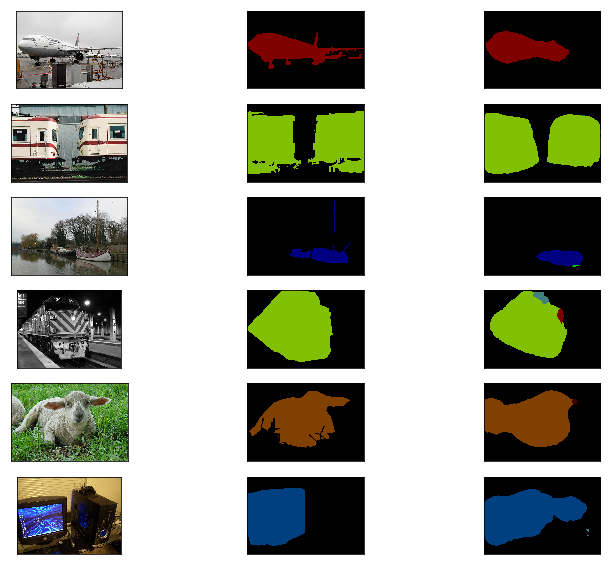

In [29]:
_, figs = plt.subplots(6, 3, figsize=(12, 10))
for i in range(6):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)